#### Import Packages

In [75]:
import numpy as np
import scipy as sci
import scipy.integrate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

#%matplotlib notebook

#### Governing Equations

In [76]:
def Force_i(rs, i, G, masses):
    '''Returns the total force on mass i'''
    
    ri = rs[i] # get position of i-th mass 
    
    F_i = np.zeros(ri.shape) # create empty force for i-th mass 
    
    # loop over other masses
    for j, rj in enumerate(rs):
        
        if i != j: 
            # print(i,j, ri, rj, np.linalg.norm(rj - ri)** 3)
            Fij = G * masses[i] * masses[j] * (rj - ri) / ((np.linalg.norm(rj - ri))** 3) # force of j-th mass on i-th mass
            F_i += Fij # sum total force on i-th mass
            
    return F_i

def dri_dt(vs, i):
    '''Returns the i-th r-derivative'''
    return vs[i]

def dvi_dt(rs, i, G, masses):
    '''Returns the i-th second r-derivative (accelation), from F = ma'''
    return Force_i(rs, i, G, masses) / masses[i]

def Force(rs, G, masses):
    '''Returns a vector of force vectors'''
    
    Fs = np.zeros_like(rs).astype('float64') # empty vector of forces 
    
    for i, r in enumerate(rs): # loop over all masses
        Fs[i] = Force_i(rs, i, G, masses) # calculate force acting on that mass
        
    return Fs

def dr_dt(vs):
    '''Returns vector of velocity vectors'''
    return vs

def dv_dt(rs, G, masses):
    '''Returns vector of accelerations from F = ma'''
    Fs = Force(rs, G, masses)
    return np.divide(Fs, masses[:, np.newaxis])

def NBodyEquations(w, t, G, masses):
    '''Takes input vector of all positions and velocities in three dimensions and returns a vector of derivatives'''
    W = np.reshape(w, (len(w) // 3, 3)) # store position and velocity in 3D
    rs, vs = np.split(W, 2) # separate positions and velocities
    
    drdt = dr_dt(vs) # find velocity of all masses
    dvdt = dv_dt(rs, G, masses) # find acceleration of all masses
    
    derivs = np.concatenate((drdt,dvdt)).flatten() # reshape as input
    
    return derivs

#### Centre of Mass

In [77]:
def CentreOfMass(rs, vs, masses):
    '''Find the position and velocity of the centre of mass, given position, velocity and mass of all masses'''
    rcom = sum([rs[i] * masses[i] for i in range(len(masses))]) / np.sum(masses)
    vcom = sum([vs[i] * masses[i] for i in range(len(masses))]) / np.sum(masses)
    return rcom, vcom

#### Energy

In [78]:
def KE(vs, i, masses):
    '''Returns the kinetic energy of mass i'''
    ke = 0.5 * masses[i] * np.linalg.norm(vs[i]) ** 2
    return ke

def KineticEnergy(vs, masses):
    '''Returns the kinetic energies of all masses, in a NumPy array'''
    ke = [KE(vs, i, masses) for i in range(len(masses))]
    return np.array(ke)

def PE(rs, i, G, masses):
    '''Returns the potential energy of mass i'''
    force_i = Force_i(rs, i, G, masses) # find force acting on the mass
    fmag = np.linalg.norm(force_i)
    rmag = np.linalg.norm(rs[i])
    return -fmag * rmag # return potential energy using E_p = - ||F_i|| * ||r_i||

def PotentialEnergy(rs, masses):
    '''Returns the potential energies of all masses, in a NumPy array'''
    Fs = Force(rs, G, masses)
    Fmags = np.linalg.norm(Fs, axis = 1)
    rmags = np.linalg.norm(rs, axis = 1)
    pe = [-1 * Fmags[i] *  rmags[i] for i in range(len(Fmags))]
    return np.array(pe)

#### Angular Momentum

In [79]:
def AM(rs, vs, i, masses):
    '''Returns the angular momentum of mass i using l = r x v'''
    l = np.cross(rs[i], masses[i]*vs[i])
    return l 

def AngMomentum(rs, vs, masses):
    '''Returns the angular momentums of all masses, in a NumPy array'''
    L = [AM(rs, vs, i, masses) for i in range(len(masses))]
    return np.array(L)

#### Relative Angular Momentum and Energy Difference

In [80]:
def EnergyDiff(kes, pes):
    '''Find the relative change in energy across a series of kinetic and potential energies'''
    total_kes = np.sum(kes, axis = 1) # total kinetic energy of system
    total_pes = np.sum(pes, axis = 1) # total potential energy of system
    Et = total_kes + total_pes # total energy of system
    E0 = Et[0] # initial energy 
    E0hat = E0 # scaling coefficient 
    
    ## conditions to avoid dividing by zero when finding relative energy
    if E0hat == 0: E0hat = np.max(np.abs(kes[0]+pes[0])) 
    if E0hat == 0: E0hat = np.max(np.abs(kes[0]))
    if E0hat == 0: E0hat = np.max(np.abs(pes[0]))
    if E0hat == 0: E0hat = 1
        
    # scale change in energy accross total, kinetic and potential energies 
    Et = (Et - E0) / np.abs(E0hat)
    kes = (total_kes - total_kes[0]) / np.abs(E0hat)
    pes = (total_pes - total_pes[0]) / np.abs(E0hat)
    
    return Et, kes, pes

def AngMomentumDiff(Ls):
    '''Find the relative change in angular momentum across a series of angular momentums'''
    Lt = np.sum(Ls, axis = 1) # total angular momentum of the system
    L0 = Lt[0] # initial angular momentum
    L0hat = L0 # scaling coefficient 
    
    ## conditions to avoid dividing by zero 
    if L0hat == 0: L0hat = np.max(np.abs(Ls))
    if L0hat == 0: L0hat = 1
        
    # scale schange in angular momentum
    lt = np.abs(Lt - L0) / np.abs(L0hat)
    return lt

#### Schemes

In [81]:
def EulerSolver(rs, vs, h, G, masses):
    '''Forward Euler Step'''
    rs_new = rs + h * dr_dt(vs)
    vs_new = vs + h * dv_dt(rs, G, masses)
    return rs_new, vs_new

def EulerCromerSolver(rs, vs, h, G, masses):
    '''Euler-Cromer Step'''
    rs = rs + h*dr_dt(vs)
    vs = vs + h*dv_dt(rs, G, masses)
    return rs, vs

def Leapfrog2(rs, vs, h, G, masses):
    '''Second order leapfrog step'''
    vs_half = vs + 0.5 * dv_dt(rs, G, masses) * h 
    rs_new = rs + vs_half * h 
    vs_new = vs_half + 0.5 * dv_dt(rs_new, G, masses) * h
    return rs_new, vs_new

def Leapfrog4(rs, vs, h, G, masses):
    '''Fourth order leapfrog step'''
    vs_half = vs + 0.5 * dv_dt(rs, G, masses) * h 
    rs_new = rs + vs_half * h 
    vs_int = vs_half + 0.5 * dv_dt(rs_new, G, masses) * h
    rs_int = rs + vs_int * h
    vs_new = vs_half + 0.5 * dv_dt(rs_int, G, masses) * h
    return rs_new, vs_new

#### Numerical Integrator

In [98]:
def run_scheme(t0, r0s, v0s, G, masses, T, h, scheme):
    '''
    Run a scheme for time period T using stepsize h from the initial positions r0s, velocities v0s with arguments G and masses.
    Returns trajectories of timesteps, positions, velocities, kinetic and potential energies, and angular momentums. 
    '''
    
    # Set the number of steps; it is best if h is an integral fraction of T
    Nsteps = int(T / h)
    
    # Make a copy of initial values
    rs = np.copy(r0s)
    vs = np.copy(v0s)
    t = t0
    
    # Initialize our saved trajectory to be blank 
    t_vals = []
    rs_traj = [] 
    vs_traj = [] 
    ke_traj = []
    pe_traj = []
    am_traj = []
    
    for n in range(Nsteps):
        rs,vs = scheme(rs, vs, h, G, masses)  # Update step
        ke = KineticEnergy(vs, masses) # Calculate kinetic energy
        pe = PotentialEnergy(rs, masses) # Calculate potential energy
        am = AngMomentum(rs, vs, masses) # Calculate angular momentum 
        
        ## append values to trajectories 
        t = t + h
        t_vals = t_vals + [t]
        rs_traj = rs_traj + [rs] 
        vs_traj = vs_traj + [vs]
        ke_traj = ke_traj + [ke]
        pe_traj = pe_traj + [pe]
        am_traj = am_traj + [am]
        
    # Make these into numpy arrays
    rs_traj = np.array(rs_traj)
    vs_traj = np.array(vs_traj) 
    am_traj = np.array(am_traj)
    return t_vals, rs_traj, vs_traj, ke_traj, pe_traj, am_traj

def run_scipy(t0, r0s, v0s, G, masses, T, h):
    '''Integrate trajectories from initial conditions using scipy'''
    
    # reshape initial conditions as a vector
    w0 = np.concatenate((r0s, v0s)).flatten()

    t_vals = np.linspace(t0,T-t0,int(T/h)) # t-vals to integrate for 
    true_sols = sci.integrate.odeint(NBodyEquations, w0, t_vals, args=(G,masses)) # integrate scheme using scipy 

    true_rs, true_vs, true_ke, true_pe, true_am = [], [], [], [], [] # create empty trajectories 
    # loop over all t-vals 
    for i, true_sol in enumerate(true_sols):
        true_sol = np.reshape(true_sol, (len(true_sol) // 3, 3)) # reshape solution to 3D
        true_r, true_v = np.split(true_sol, 2) # get true position and velocities 
        true_rs.append(true_r)
        true_vs.append(true_v)
        true_ke.append(KineticEnergy(true_v, masses)) # kinetic energy trajectory 
        true_pe.append(PotentialEnergy(true_r, masses)) # potential energy trajectory 
        true_am.append(AngMomentum(true_r, true_v, masses)) # angular momentum trajectory 

    # make trajectories NumPy arrays
    true_rs = np.array(true_rs)
    true_vs = np.array(true_vs)
    true_am = np.array(true_am)
    
    return t_vals, true_rs, true_vs, true_ke, true_pe, true_am

#### Plotting Function

In [83]:
def plot2D(t_traj, rs_traj, ke_traj, pe_traj, am_traj, scheme='',dark = True):
    '''Given trajectories of times, positions, energies and angular momentums, plot the orbits, energy and angular momentum'''
    
    # find how many masses are in the system and defind colourspace for plotting 
    N = rs_traj.shape[1]
    colours = plt.cm.rainbow(np.linspace(0,1,N))
    
    colourface = 'black'
    if dark == True: 
        plt.style.use('dark_background')
        colourface = 'white'
        
    # create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))

    ### ORBITS ###
    
    # loop over all masses 
    for i in range(N):
        ri_traj = rs_traj[:,i,:] # get the i-th trajectory
        ax1.plot(ri_traj[:,0], ri_traj[:,1], color = colours[i],linestyle='-', zorder = 1, label=f'mass {i+1}') # plot the orbits
        ax1.scatter(ri_traj[0,0],ri_traj[0,1],color=colours[i],marker="o", facecolors='none', s=50, zorder = 2) # plot the start positions
        ax1.scatter(ri_traj[-1,0],ri_traj[-1,1],color=colours[i],marker="o",s=50, zorder = 2) # plot the final positions of the
    
    # find and plot the centre of mass
    rcoms = []
    for i in range(rs_traj.shape[0]):
        rcom, vcom = CentreOfMass(r0s, v0s, masses)
        rcoms = rcoms + [rcom]
    rcoms = np.array(rcoms)
    ax1.scatter(rcoms[:,0], rcoms[:,1], color = colourface, label = 'Centre of mass', marker = 'x', zorder = 3)
    
    ax1.set_title(f'Trajectories of {N} masses in $z=0$ using {scheme}')
    ax1.set_xlabel('x-coordinate')
    ax1.set_ylabel('y-coordinate')
    ax1.legend()
    
    ### ENERGY ###
    
    # get the relative change in energy 
    relative_e_traj, relative_ke_traj, relative_pe_traj = EnergyDiff(ke_traj, pe_traj)
    
    ax2.plot(t_traj, relative_ke_traj, color = 'red', label = 'Kinetic Energy')
    ax2.plot(t_traj, relative_pe_traj, color = 'blue', label = 'Potential Energy')
    ax2.plot(t_traj, relative_e_traj, color = colourface, linestyle = '--', label = 'Total Energy')
    
    ax2.set_title(f'Relative energy difference of the system using {scheme}')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Relative Energy Difference')
    ax2.legend()
    
    ### ANGULAR MOMENTUM ###
    
    am_traj = am_traj[:,:,-1]
    relative_am_traj = AngMomentumDiff(am_traj)
    
    ax3.plot(t_traj, relative_am_traj)
    ax3.set_title(f'Relative change in angular momentum using {scheme}')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Relative Angular Momentum Difference')
    

#### Initial Conditions

In [84]:
# gravity
G = 1

# masses
m1 = 1
m2 = 1 
m3 = 1

# position
r1 = np.array([-1.0,0.0,0.0], dtype="float64")
r2 = np.array([1.0,0.0,0.0], dtype="float64")
r3 = np.array([0.0,0.0,0.0], dtype="float64")

# velocity 
v1 = np.array([0.347113,0.532727,0], dtype="float64")
v2 = np.array([0.347113,0.532727,0], dtype="float64")
v3 = np.array([-0.694226,-1.065454,0], dtype="float64") 

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

# reposition centre of mass to origin with no momentum 
rcom, vcom = CentreOfMass(r0s, v0s, masses)
r0s -= rcom
v0s -= vcom

#### Run Schemes

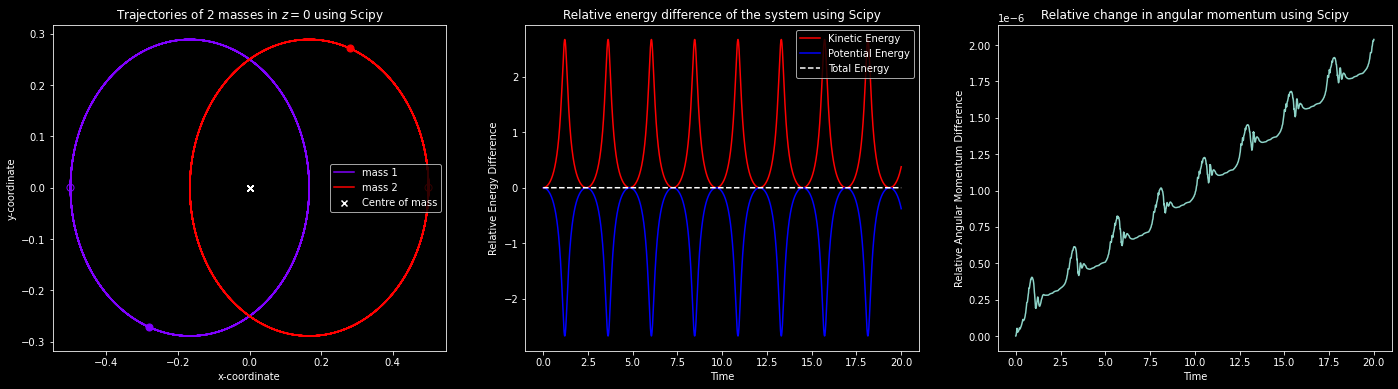

In [100]:
### Truth ###
t_vals, true_rs, true_vs, true_ke, true_pe, true_am = run_scipy(0, r0s, v0s, G, masses, 20, 0.01)
plot2D(t_vals, true_rs, true_ke, true_pe, true_am, 'Scipy')

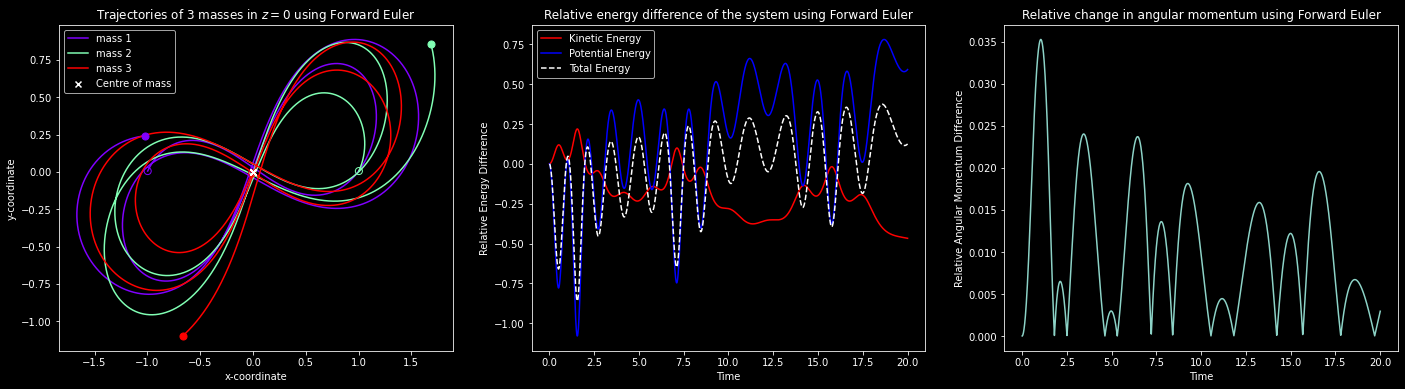

In [86]:
### Forward Euler ###
Euler_ts, Euler_rs, Euler_vs, Euler_ke, Euler_pe, Euler_am = run_scheme(0, r0s, v0s, G, masses, 20, 0.01, EulerSolver)
plot2D(Euler_ts, Euler_rs, Euler_ke, Euler_pe, Euler_am, 'Forward Euler')

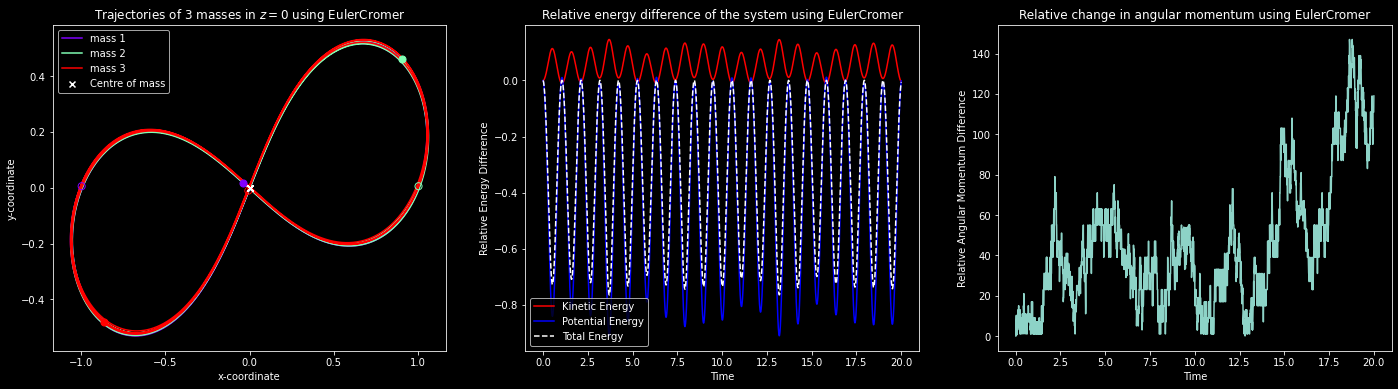

In [87]:
### Euler Cromer ###
EulerCromer_ts, EulerCromer_rs, EulerCromer_vs, EulerCromer_ke, EulerCromer_pe, EulerCromer_am = run_scheme(0, r0s, v0s, G, masses, 20, 0.01, EulerCromerSolver)
plot2D(EulerCromer_ts, EulerCromer_rs, EulerCromer_ke, EulerCromer_pe, EulerCromer_am, 'EulerCromer')

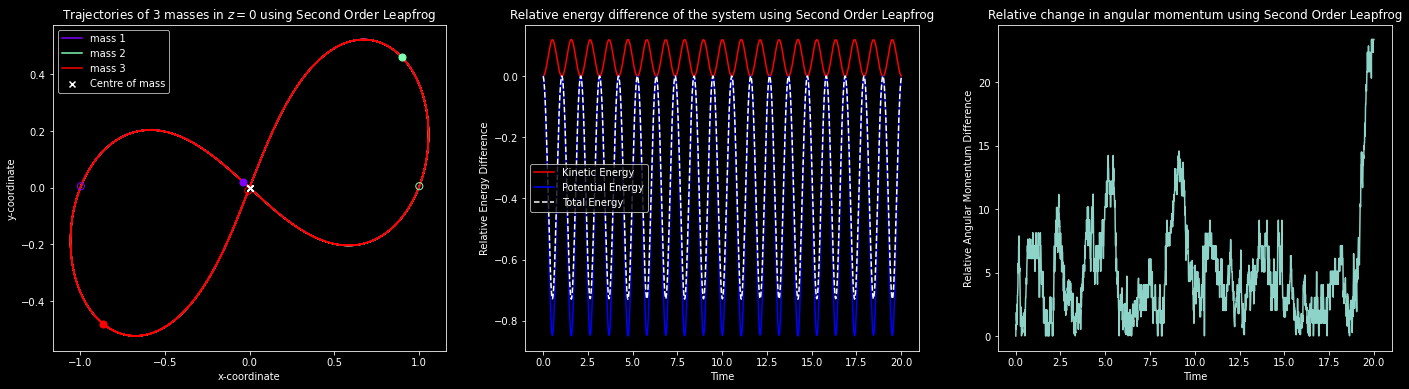

In [88]:
### Second Order Leapfrog ###
Leapfrog_ts, Leapfrog_rs, Leapfrog_vs, Leapfrog_ke, Leapfrog_pe, Leapfrog_am = run_scheme(0, r0s, v0s, G, masses, 20, 0.01, Leapfrog2)
plot2D(Leapfrog_ts, Leapfrog_rs, Leapfrog_ke, Leapfrog_pe, Leapfrog_am, 'Second Order Leapfrog')

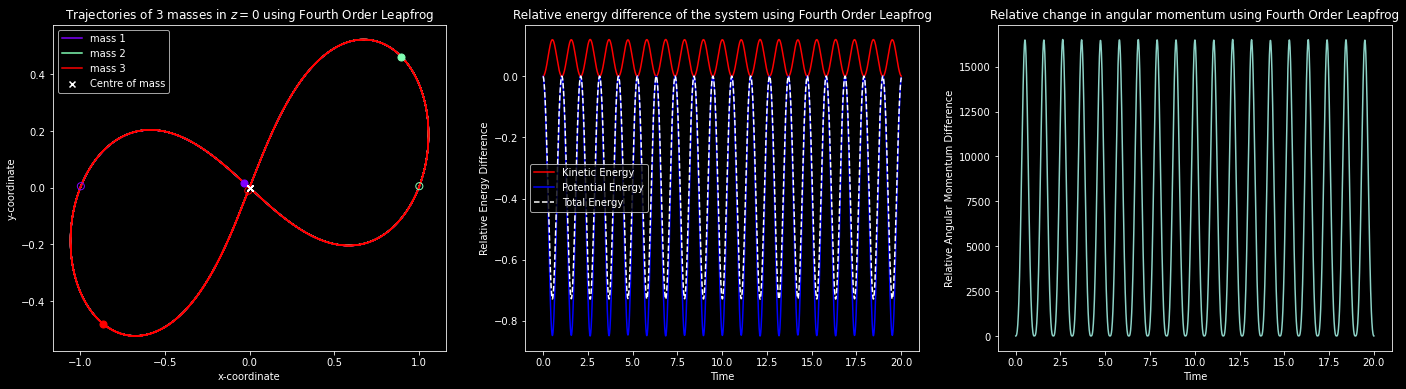

In [89]:
### Fourth Order Leapfrog ###
Leapfrog_ts, Leapfrog_rs, Leapfrog_vs, Leapfrog_ke, Leapfrog_pe, Leapfrog_am = run_scheme(0, r0s, v0s, G, masses, 20, 0.01, Leapfrog4)
plot2D(Leapfrog_ts, Leapfrog_rs, Leapfrog_ke, Leapfrog_pe, Leapfrog_am, 'Fourth Order Leapfrog')

#### Kepler Orbits

In [90]:
# gravity
G = 1

# masses
m1 = 1
m2 = 1 
m3 = 1

# position
r1 = np.array([0.0,0.0,0.0], dtype="float64")
r2 = np.array([1.0,0.0,0.0], dtype="float64")

# velocity 
v1 = np.array([0,0,0], dtype="float64")
v2 = np.array([0,1.0,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2])
v0s = np.array([v1,v2])
masses = np.array([m1, m2])

# reposition centre of mass to origin with no momentum 
rcom, vcom = CentreOfMass(r0s, v0s, masses)
r0s -= rcom
v0s -= vcom

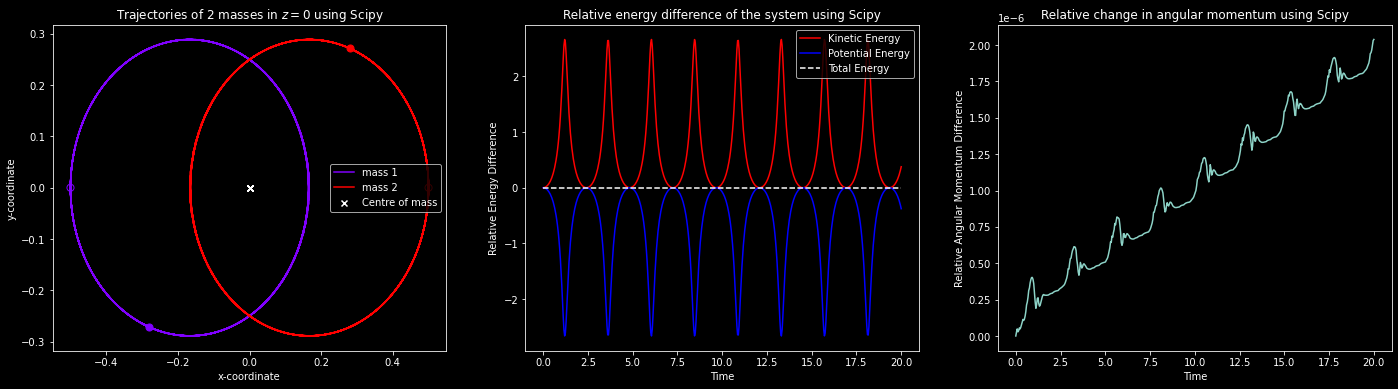

In [91]:
### Truth ###

# initial conditions as a long vector
w0 = np.concatenate((r0s, v0s)).flatten()

t_vals = np.linspace(0,20,500) 
true_sols = sci.integrate.odeint(NBodyEquations, w0, t_vals, args=(G,masses))

true_rs, true_vs, true_ke, true_pe, true_am = [], [], [], [], []
for i, true_sol in enumerate(true_sols):
    true_sol = np.reshape(true_sol, (len(true_sol) // 3, 3))
    true_r, true_v = np.split(true_sol, 2)
    true_rs.append(true_r)
    true_vs.append(true_v)
    true_ke.append(KineticEnergy(true_v, masses))
    true_pe.append(PotentialEnergy(true_r, masses))
    true_am.append(AngMomentum(true_r, true_v, masses))

true_rs = np.array(true_rs)
true_vs = np.array(true_vs)
true_am = np.array(true_am)

plot2D(t_vals, true_rs, true_ke, true_pe, true_am, 'Scipy')

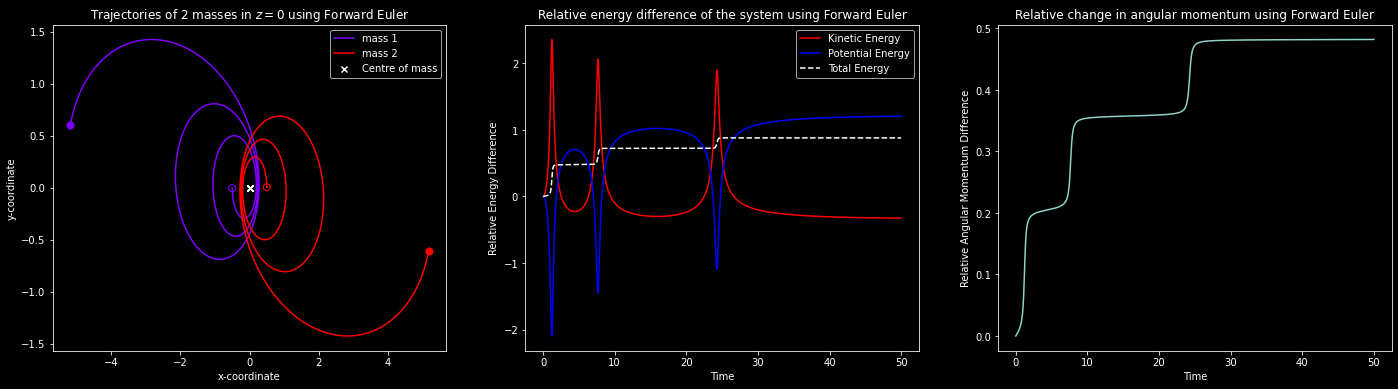

In [92]:
### Forward Euler ###
Euler_ts, Euler_rs, Euler_vs, Euler_ke, Euler_pe, Euler_am = run_scheme(0, r0s, v0s, G, masses, 50, 0.01, EulerSolver)
plot2D(Euler_ts, Euler_rs, Euler_ke, Euler_pe, Euler_am, 'Forward Euler')

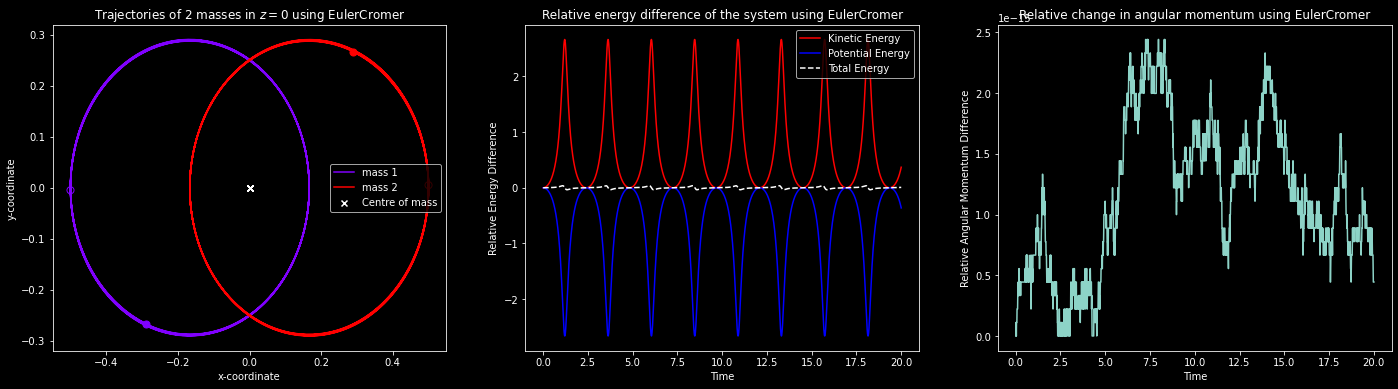

In [93]:
### Euler Cromer ###
EulerCromer_ts, EulerCromer_rs, EulerCromer_vs, EulerCromer_ke, EulerCromer_pe, EulerCromer_am = run_scheme(0, r0s, v0s, G, masses, 20, 0.01, EulerCromerSolver)
plot2D(EulerCromer_ts, EulerCromer_rs, EulerCromer_ke, EulerCromer_pe, EulerCromer_am, 'EulerCromer')

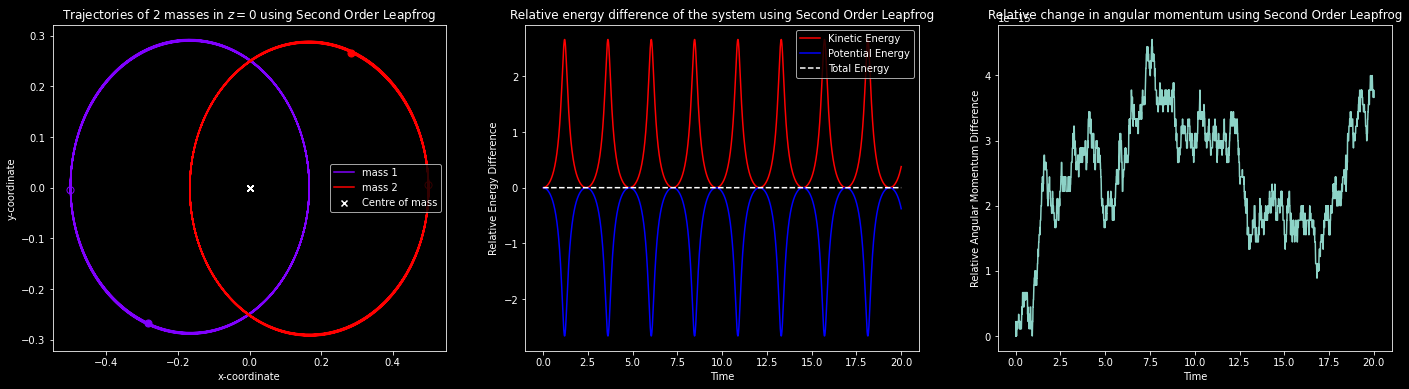

In [94]:
### Second Order Leapfrog ###
Leapfrog_ts, Leapfrog_rs, Leapfrog_vs, Leapfrog_ke, Leapfrog_pe, Leapfrog_am = run_scheme(0, r0s, v0s, G, masses, 20, 0.01, Leapfrog2)
plot2D(Leapfrog_ts, Leapfrog_rs, Leapfrog_ke, Leapfrog_pe, Leapfrog_am, 'Second Order Leapfrog')

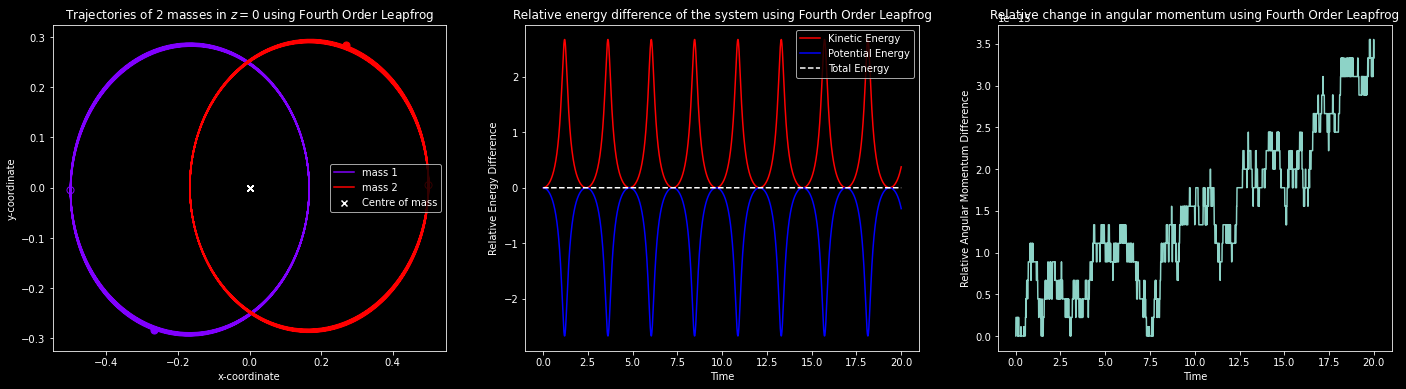

In [95]:
### Fourth Order Leapfrog ###
Leapfrog_ts, Leapfrog_rs, Leapfrog_vs, Leapfrog_ke, Leapfrog_pe, Leapfrog_am = run_scheme(0, r0s, v0s, G, masses, 20, 0.01, Leapfrog4)
plot2D(Leapfrog_ts, Leapfrog_rs, Leapfrog_ke, Leapfrog_pe, Leapfrog_am, 'Fourth Order Leapfrog')

#### 